In [1]:
import sys, os

EDL_DIR = os.getcwd() # used to allow easy saving on any computer 
DOC = os.path.dirname(EDL_DIR)
sys.path.append("./EntryGuidance")

from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat
import pickle
from time import time

import numpy as np
import chaospy as cp 
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils import Unscented 
from Utils import MCF
from Utils import smooth

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 
from EntryGuidance.Triggers import AltitudeTrigger
from EntryGuidance.VMC import VMC, velocity_trigger
from EntryGuidance.EntryVehicle import ConstantAeroEV

np.set_printoptions(suppress=True, precision=3)

# Monte Carlo Filtering Functions for Analysis

In [2]:
def range_error(xf, mean, mean_error):
    err = np.abs(xf[1] - mean)  # absolute error
    return err < mean_error # behavioral when error is less than the mean

def MCAnalyze(inputs, xf):
    mean = np.mean(xf[:,1], axis=0)
    err = np.mean(np.abs(xf[:,1] - mean))  #mean of absolute error
    
    data = MCF.mcsplit(inputs, xf, lambda x: range_error(x, mean, err))
    MCF.mcfilter(*data, plot=True, input_names=['h0','s0','v0','fpa0','CD','CL','rho'], ks_threshold=0, p_threshold=0.3)

# DDP Controller Definition

In [3]:
def smooth_sat(x, tuning=20):
    """Another saturation function, from 
    Saturated Robust Adaptive Control for Uncertain Nonlinear Systems using a new approximate model
    
    """
    q = 2*x-1
    return 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))

class ddp_controller:

    def __init__(self, data):
        v = data['v'].squeeze()
        u0 = data['u'].copy() # feedfoward term 
        if len(u0.shape)>1 and u0.shape[0]>1:
            if data['u'].shape[0] == 2:
                print('Fixed Gain + Overcontrol')
                G = data['input']['gains'].squeeze()
                k = np.array([data['u'][1]*g for g in G])
                K = interp1d(v[:-1], k, bounds_error=False, fill_value=(k[:,-2], k[:,0]))
            else:
                K = interp1d(v[:-1], data['u'][1:], bounds_error=False, fill_value=(data['u'][1:,-2], data['u'][1:,0]))
            u0 = u0[0]

        else:
            if 'gains' in data:
                G = data['gains'].squeeze()
            else:
                G = data['input']['gains'].squeeze()
#             G[2] = np.clip(G[2], -10, 10)
            K = lambda v: G
            print("Fixed Gain Controller, ", G)
        
        u0[-1] = u0[-2]
        u0 = np.append(u0, u0[-2])    
        u0 *= data['Lm']/data['Dm'] # converts to reference L/D, more robust 
        self.K = K
        self.u = interp1d(v, u0, bounds_error=False, fill_value=(u0[-1],u0[0]))
        xr = np.vstack([data['Dm'], data['mean'][1:]])
        self.ref = interp1d(v, xr, bounds_error=False, fill_value=(xr[:,-1],xr[:,0]))
        

    def __call__(self, E, x, L, D, saturate=True):
        # This function is used in VMC to generate the controls
        
        # compute error states, apply gains
        if len(x) == 5:
            r,s,v,fpa,_ = x
        else:
            r,s,fpa,_ = x
            v = E
        
        xr = self.ref(v)
        eD = D - xr[0]
        es = s/1000 - xr[2]
        ef = fpa - xr[1]
        K = self.K(v)
        if 0:
            print(K)
#             print(eD, es, np.degrees(ef))
#             print(xr)
        u = self.u(v)*D/L + K[0]*eD + K[1]*es + K[2]*ef
        if saturate:
            u = smooth_sat(u)
#         u = np.clip(u, 0, 1)
#         u = np.clip(self.u(v) + K[0]*eD + K[1]*es + K[2]*ef, 0, 1)
        
#         u[np.isnan(u)] = 1
        
        return u
    

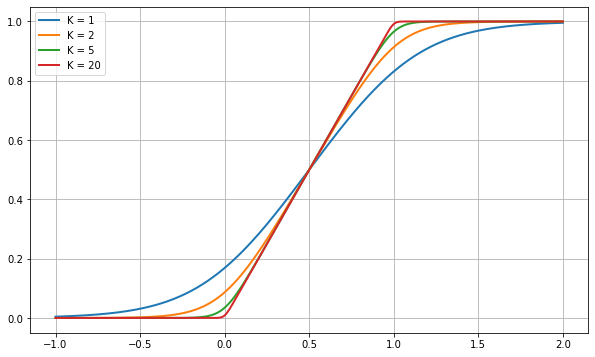

In [4]:
x = np.linspace(-1, 2, 1000)

plt.figure(figsize=(10,6))
for K in [1,2,5,20]:
    plt.plot(x, smooth_sat(x,K), label='K = {}'.format(K), linewidth=2)
plt.grid(1)
plt.legend()
# plt.savefig("./Documents/Seminar/smooth_saturation",bbox_inches='tight')
plt.show()

# Monte Carlo Functions

In [9]:
def MonteCarlo(data, N=2000, debug=False, parametric=False, sample='L'):
    """ Runs a monte carlo from a DDP solution and compares to UT results
    
        debug = True runs the unscented transform points to ensure those match 
    """
    print(data['input']['weights'])
    P0 = data['input']['P0']  # h fpa s (no velocity term) 
    
    mass = 5000.

    x0 = data['mean'].T[0]
    if debug:
        N = 7
        X0 = np.reshape(data['X0'].squeeze(), (3,N))
        X0[2] *= 1000 # data is in km, need meters 
        
    else:
        X0 = cp.MvNormal(x0, P0).sample(N, sample)

#     if len(data['v'][0]) > 1:
#         data['v'] = np.squeeze(data['v'][0])

    # reorder and add velocity terms - h s v gamma
    X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
    
    mc = VMC()
    mc.null_sample(N)
    if parametric:
        mc.sample(N) # TODO: reset to zero whichever ones we aren't modeling in Matlab
        mc.samples[3] = 0 # no scale height variations 

    mc.control = ddp_controller(data)
    mc.set_trigger(velocity_trigger(data['v'][-1]))

    vehicle = lambda CD,CL: ConstantAeroEV(1.3736, 0.3986, CD=CD, CL=CL, area=16.1781)
    
    mc._run(X0, stepsize=[5, 0.1, 1], Ef=10000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

    keep = np.isfinite(mc.xf)
    print(np.shape(keep))
    xf = np.reshape(mc.xf[keep], (-1,5))
    mean = np.mean(xf, axis=0)
    std = np.std(xf, axis=0)
        
    stochastic = 'var' in data
    if stochastic:
        hlow = data['mean'][0,-1]/1000 - 3*data['var'][0,-1]**0.5/1000
        std_ddp = [data['mean'][0,-1]/1000, hlow, 3*data['var'][2,-1]**0.5]
    else:
        print("Nominal opt, setting DDP mean/var to zeros")
        std_ddp = [0,0,0]
#     if len(data['stats']) > 3:
#         std_ddp = [data['stats'][0], data['stats'][0] - 3*data['stats'][3]**0.5, 3*data['stats'][5]**0.5]
#     else:
#         std_ddp = data['stats'].squeeze()
    if debug:
        print("Running in debug mode to recreate the unscented trajectories, disregard the MC values below")
        
    print("Mean Altitude\n\tDDP: {:.3f} km\n\tMC:  {:.3f} km".format(std_ddp[0], mean[0]/1000-3396.2))
    print("3-sigma Low Altitude\n\tDDP: {:.3f} km\n\tMC:  {:.3f} km".format(std_ddp[1], mean[0]/1000-3396.2-3*std[0]/1000))
    print("3-sigma DR\n\tDDP: {:.3f} km\n\tMC:  {:.3f} km".format(std_ddp[2], 3*std[1]/1000))        
    output = np.array([std_ddp[1],  mean[0]/1000-3396.2-3*std[0]/1000, std_ddp[2], 3*std[1]/1000]) # hlow_ddp hlow_mc, 3s_ddp 3s_mc
    return {'output': output, 'mc': mc} 

In [10]:
def build_dict(sol):
    """ Matlab mat files get loaded with a weird dtype and as zero-length arrays,
    this utility builds a standard python dict that is easier to work with and handles recursive structures"""
    output = {}
    
    for name in sol.dtype.names:
        if isinstance(sol[name][()], (float,int)) or sol[name][()].dtype.names is None:
            output[name] = sol[name][()]
        else:
            output[name] = build_dict(sol[name][()])
    return output

def MonteCarloArray(mdir, mc_kwargs={}, plot=True):
    """ Runs Monte Carlos for a variety of solutions and plots the results in a variety of ways
    Designed for sweeps over the objective function weights 
    """
    # Old separate mat file format:
#     files = [fname for fname in list(os.walk(mdir))[0][2] if '.mat' in fname and not 'Matlab' in fname]
#     print(files)
#     dlist = [loadmat(os.path.join(mdir,fname)) for fname in list(os.walk(mdir))[0][2] if '.mat' in fname and not 'Matlab' in fname]

    # New way with sols in an array 
    dlist = mdir['sols']
    outputs = np.array([MonteCarlo(build_dict(data), **mc_kwargs)['output'] for data in dlist])
    print(outputs.shape)
    w = np.squeeze([build_dict(data)['weights'] for data in dlist]).T
    
    data = {'stats': outputs, 'weights': w}
    if plot:
        MCAPlots(data)
    
    return data
    
def MCAPlots(results):    

    outputs = results['stats']
    w = results['weights']
    best = np.argmin(outputs[:,3]) # lowest MC range error
    print(w.T[best])
    print(outputs[best]) # low alt, 3s range error 

    # Monte Carlo estimated results for different weights 
    N = 30
    hmin = min(np.min(outputs[:,0]), np.min(outputs[:,1]))
    hmax = max(np.max(outputs[:,0]), np.max(outputs[:,1]))
    print('Alt range: {}-{}'.format(hmin, hmax))
    smin = min(np.min(outputs[:,2]), np.min(outputs[:,3]))
    smax = max(np.max(outputs[:,2]), np.max(outputs[:,3]))
    print('S range: {}-{}'.format(smin, smax))
    
    hdraw = np.linspace(hmin, hmax, N)
    sdraw = np.linspace(smin, smax, N)

    fs = 16
    try:
# Monte Carlo Results
        plt.figure(figsize=(20, 6))

        plt.subplot(1, 2, 1)
        plt.tricontourf(w[0], w[1], outputs[:,1], N)
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)
        plt.colorbar()
        plt.title(r'3$\sigma$-Low Altitude (km)', fontsize=fs)
        plt.subplot(1, 2, 2)
        plt.tricontourf(w[0], w[1], outputs[:,3], N)
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)    
        plt.title(r'3$\sigma$ Range Error (km)', fontsize=fs)
        plt.colorbar()

        # Comparisons between UT and MC
        plt.figure(figsize=(20, 6))
        plt.suptitle(r'3$\sigma$-Low Altitude (km)', fontsize=fs)

        plt.subplot(1, 2, 1)
        plt.tricontourf(w[0], w[1], outputs[:,0], hdraw)
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        plt.title('DDP', fontsize=fs)
        plt.subplot(1, 2, 2)
        plt.tricontourf(w[0], w[1], outputs[:,1], hdraw)
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)    
        plt.title('MC', fontsize=fs)
        plt.colorbar()

        plt.figure(figsize=(20, 6))
        plt.suptitle('3$\sigma$ Range Errors (km)', fontsize=fs)
        plt.subplot(1, 2, 1)
        plt.title('DDP', fontsize=fs-2)
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)
        plt.tricontourf(w[0], w[1], outputs[:,2], sdraw)
        plt.subplot(1, 2, 2)
        plt.title('MC', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], outputs[:,3], sdraw)
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)
        plt.colorbar()

        # TODO: show error plots between DDP and MC in asbolute units and maybe also as a percent difference?
        plt.figure(figsize=(14, 6))
        plt.suptitle('UT - MC (positive indicates an overestimate)', fontsize=fs)
        plt.subplot(1, 2, 1)
        plt.title(r'$3\sigma$-Low Altitude UT Estimation Error (km)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], (outputs[:,0]-outputs[:,1]))
        plt.colorbar()
        plt.tricontour(w[0], w[1], (outputs[:,0]-outputs[:,1]), [0])
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        plt.subplot(1, 2, 2)
        plt.title(r'3$\sigma$ Range Error UT Estimation Error (km)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], (outputs[:,2]-outputs[:,3]))
        plt.colorbar()    
        plt.tricontour(w[0], w[1], (outputs[:,2]-outputs[:,3]), [0]) # show the divide between over and under predictions 
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        # Percent errors 
        plt.figure(figsize=(14, 6))
        plt.suptitle('UT - MC (positive indicates an overestimate)', fontsize=fs)
        plt.subplot(1, 2, 1)
        plt.title(r'$3\sigma$-Low Altitude UT Estimation Error (%)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], 100*(outputs[:,0]-outputs[:,1])/outputs[:,1])            
        plt.colorbar()
        plt.tricontour(w[0], w[1], 100*(outputs[:,0]-outputs[:,1])/outputs[:,1],[0])
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        plt.subplot(1, 2, 2)
        plt.title(r'3$\sigma$ Range Error UT Estimation Error (%)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], 100*(outputs[:,2]-outputs[:,3])/outputs[:,3])
        plt.colorbar()    
        plt.tricontour(w[0], w[1], 100*(outputs[:,2]-outputs[:,3])/outputs[:,3], [0]) # show the divide between over and under predictions 
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        # Altitude vs Range Error
    #     plt.figure(figsize=(14, 6))
    #     plt.suptitle('Trade Off', fontsize=fs)
    #     plt.subplot(1, 2, 1)
    #     plt.title('DDP', fontsize=fs)
    #     plt.scatter(outputs[:,1,0], outputs[:,0,0])
    #     plt.xlabel('3sigma Range Error (km)')
    #     plt.ylabel('3sigma Low Altitude (km)')

    #     plt.subplot(1, 2, 2)
    #     plt.title('MC')
    #     plt.scatter(outputs[:,1,1], outputs[:,0,1])
    #     plt.xlabel('3sigma Range Error (km)')
    #     plt.ylabel('3sigma Low Altitude (km)')    
    except Exception as e:
        print(e)
plt.show()


In [ ]:
# TODO: MC function that compares DDP controller to Apollo? Take the reference and get adjoints, perform a second VMC, then compare stats and plots 

In [ ]:
sols = [build_dict(sol) for sol in data['sols']]
w = np.vstack([sol['weights'] for sol in sols])
print(w)

In [ ]:
sols[0]['input']['gains']

In [ ]:
print(w[0],w[12],w[3])
fs = 16
colors = ['b','r','y']
j = 0
plt.figure(figsize=(8,6))
for i in [0,12,3]:
    sol = sols[i]
    u = smooth.smooth(sol['v'][1:][::-1],sol['u'][::-1], 3, 50)(sol['v'][1:])
#     u = sol['u']
    plt.plot(sol['v'][1:], u, label=r'$w_h={:n}, w_s={:n}$'.format(*sol['weights'][:-1]), linewidth=4, c=colors[j])
    j += 1

plt.xlabel('Velocity (m/s)', fontsize=fs)
plt.ylabel(r'$\cos\sigma$ (-)', fontsize=fs)
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.grid(1)
plt.legend()
plt.savefig(r'C:\Users\cdnoyes\Documents\EDL\Documents\PropellantOptimalJournal\ddp\matlab\RobustControl.png', bbox_inches='tight')
plt.show()

In [43]:
sol = MonteCarlo(build_dict(data['sols'][3]), 10, debug=False, parametric=True)

[3.  0.  0.2]
 
Generating 10 samples...
 
Generating 10 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [  0.714  -0.212 -64.97 ]
Something wrong
(10, 5)
Mean Altitude
	DDP: 4.663 km
	MC:  4.592 km
3-sigma Low Altitude
	DDP: 1.972 km
	MC:  2.212 km
3-sigma DR
	DDP: 4.975 km
	MC:  4.601 km


<ipython-input-30-878193b3a72a>:7: RuntimeWarning: overflow encountered in cosh
  return 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))


In [26]:
def data_loader(fname):
    return loadmat(os.path.join(DOC, 'GitHub\\Research\\Matlab\\', fname), squeeze_me=True) 

# data = loadmat(os.path.join(DOC,'GitHub\\Research\\Matlab\\iLQR','overcontrol_test.mat'), squeeze_me=True)
# data = loadmat(os.path.join(DOC,'GitHub\\Research\\Matlab\\','LDtest.mat'), squeeze_me=True)

# data = loadmat(os.path.join(DOC,'GitHub\\Research\\Matlab\\','UTScale.mat'), squeeze_me=True)

# files:
# margin_comparison = six cases each with the nominal fixed gains
# reference_comparison_fixed_gains.mat = same six cases but with gains optimized for the 6th trajectory to minimize range errors
# reference_comparison_opt_gains.mat = same six cases but with different fixed gains optimized for each trajectory 

# weight sweep files:
# data = data_loader('solutions_cl_ddp_max.mat')     # using previous solution as guess 
# 'solutions_cl_ddp_max_guess.mat'), squeeze_me=True) # all with same nominal guess
# 'solutions_cl_ddp_optimized.mat'), squeeze_me=True) # reoptimized gains for each sol

# data = data_loader('margin_comparison')

In [29]:
data = data_loader('margin_comparison')
stats = MonteCarloArray(data, {'N': 8000, 'parametric': True, 'sample': 'L'}, plot=False)

[0 0 0]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
(8000, 5)
Nominal opt, setting DDP mean/var to zeros
Mean Altitude
	DDP: 0.000 km
	MC:  6.387 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  2.863 km
3-sigma DR
	DDP: 0.000 km
	MC:  17.663 km
[0 0 0]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
(8000, 5)
Nominal opt, setting DDP mean/var to zeros
Mean Altitude
	DDP: 0.000 km
	MC:  6.200 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  3.532 km
3-sigma DR
	DDP: 0.000 km
	MC:  14.055 km
[0 0 0]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
(8000, 5)
Nominal opt, setting DDP mean/var to zeros
Mean Altitude
	DDP: 0.000 km
	MC:  4.808 km
3-si

## Fixed gain for improved case 6

In [31]:
data = data_loader('reference_comparison_fixed_gains.mat')
stats = MonteCarloArray(data, {'N': 8000, 'parametric': True, 'sample': 'L'}, plot=False)

[0 0 0]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.07  -0.024 -5.225]
(8000, 5)
Nominal opt, setting DDP mean/var to zeros
Mean Altitude
	DDP: 0.000 km
	MC:  6.438 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  3.043 km
3-sigma DR
	DDP: 0.000 km
	MC:  18.504 km
[0 0 0]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.07  -0.024 -5.225]
(8000, 5)
Nominal opt, setting DDP mean/var to zeros
Mean Altitude
	DDP: 0.000 km
	MC:  6.205 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  3.549 km
3-sigma DR
	DDP: 0.000 km
	MC:  14.311 km
[0 0 0]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.07  -0.024 -5.225]
(8000, 5)
Nominal opt, setting DDP mean/var to zeros
Mean Altitude
	DDP: 0.000 km
	MC:  4.804 km
3-si

## Gains reoptimized for each of the 6 cases

In [32]:
data = data_loader('reference_comparison_opt_gains.mat')
stats = MonteCarloArray(data, {'N': 8000, 'parametric': True, 'sample': 'L'}, plot=False)

[0.   0.01 0.  ]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [0.023 0.    2.653]
(8000, 5)
Mean Altitude
	DDP: 7.141 km
	MC:  6.846 km
3-sigma Low Altitude
	DDP: 4.546 km
	MC:  4.569 km
3-sigma DR
	DDP: 54.551 km
	MC:  53.903 km
[0.   0.01 0.  ]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.027 -0.001  3.072]
(8000, 5)
Mean Altitude
	DDP: 6.583 km
	MC:  6.357 km
3-sigma Low Altitude
	DDP: 4.231 km
	MC:  4.173 km
3-sigma DR
	DDP: 38.498 km
	MC:  37.840 km
[0.   0.01 0.  ]
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.048 -0.015  1.74 ]
(8000, 5)
Mean Altitude
	DDP: 5.054 km
	MC:  4.928 km
3-sigma Low Altitude
	DDP: 1.938 km
	MC:  2.363 km
3-sigma DR
	DDP: 7.246 km
	MC:  12.252 km
[0.   0.01 0.2

[3.  3.  0.2]
[2.502 2.469 1.014 1.564]
Alt range: 2.463917615520028-4.425957493613787
S range: 0.8521940224902012-39.165581035369925


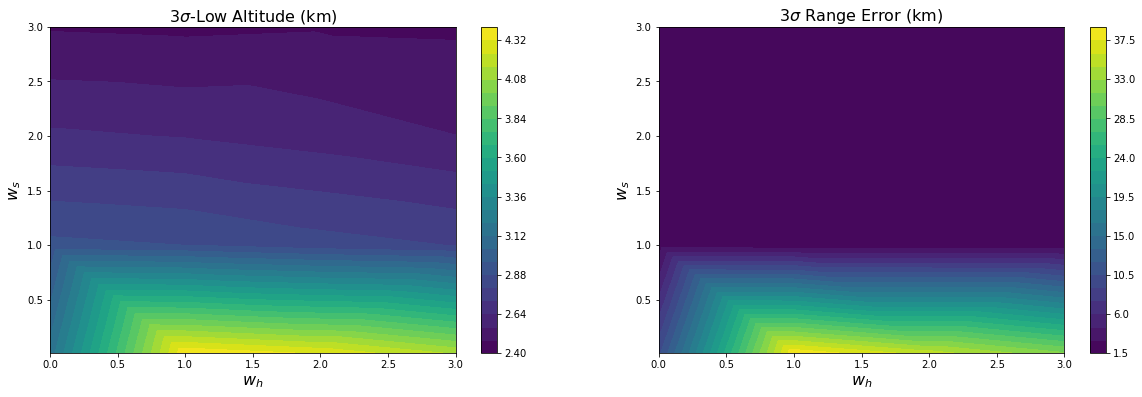

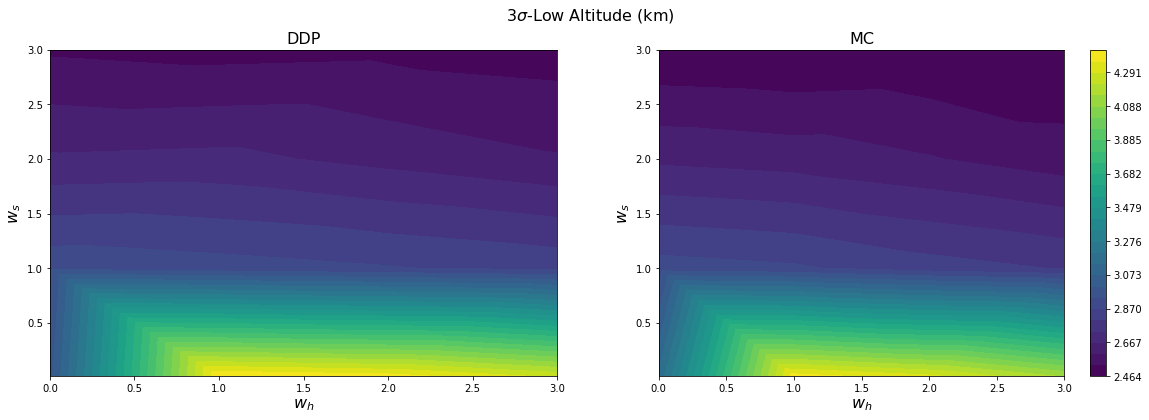

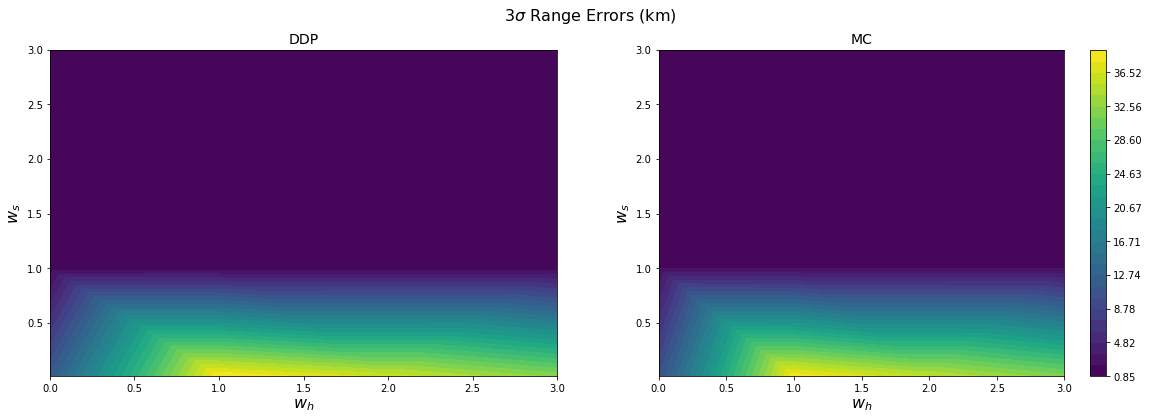

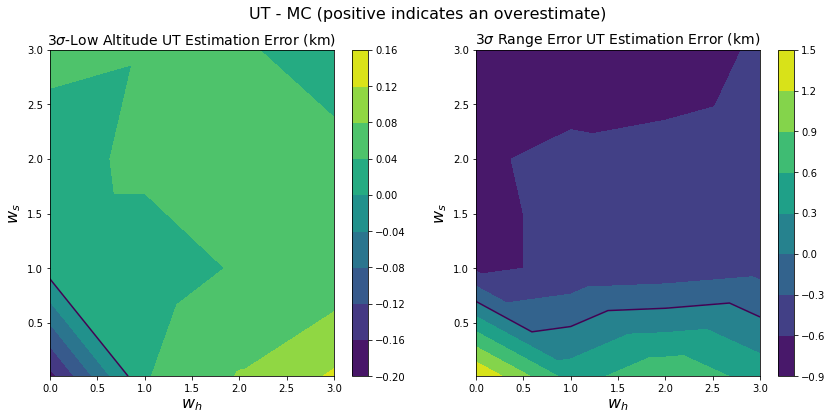

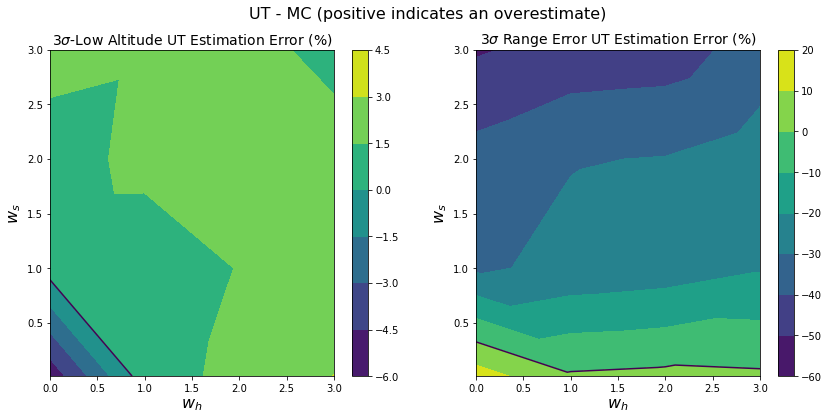

In [13]:
MCAPlots(stats)

In [98]:
pydata = build_dict(data['sols'][-1])

In [99]:
sol = MonteCarlo(pydata, 2000, debug=False, parametric=True)

[3.  1.  0.2]
 
Generating 2000 samples...
 
Generating 2000 samples...
     Sobol sampling method
     Parametric uncertainty only
Mean Altitude
	DDP: 5.348 km
	MC:  5.231 km
3-sigma Low Altitude
	DDP: 3.021 km
	MC:  3.056 km
3-sigma DR
	DDP: 0.029 km
	MC:  3.075 km


699 cases (34.95%) are non-behavioral.

Input   KS      P
--------------------
CD     0.29   0.000
CL     0.28   0.000
h0     0.20   0.000
fpa0   0.11   0.000
s0     0.08   0.008




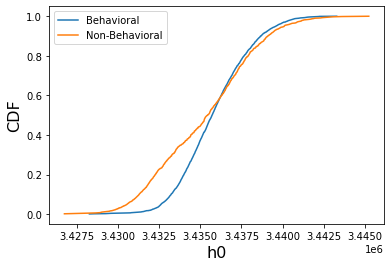

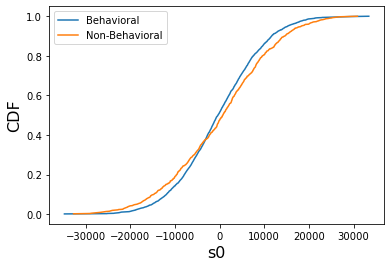

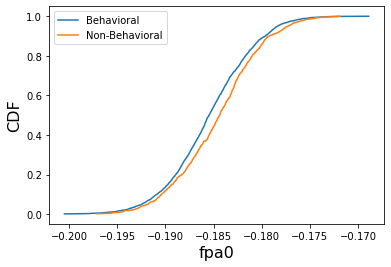

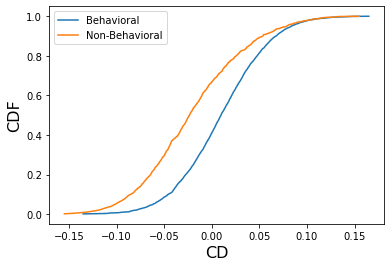

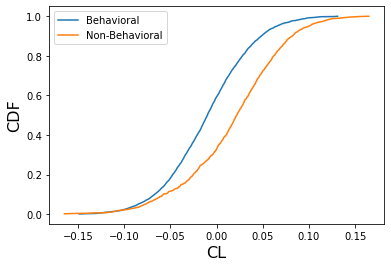

In [106]:
mc = sol['mc']
x0 = mc.mc_full['state'][0][:-1]
p0 = mc.samples
# print(x0.shape, p0.shape)
X0 = np.vstack([x0,p0])
# print(X0.shape)
MCAnalyze(X0[:-1], mc.xf)

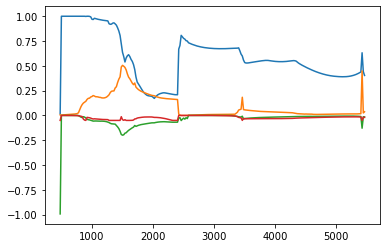

In [96]:
plt.plot(pydata['v'][:-1],pydata['u'].T)

# Single MC Analysis
Individualized plots, etc.

In [ ]:
# data = loadmat(os.path.join("E:\\Documents\\GitHub\\Research\\Matlab",'Beta5.mat'))
# data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\beta_sweep','Beta16.mat'))
# data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\fixed_gain','Sol22.mat'))
data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\margin','Sol2.mat'))


sol = MonteCarlo(data, 3000, debug=False, parametric=True)

KeyError: 'v'

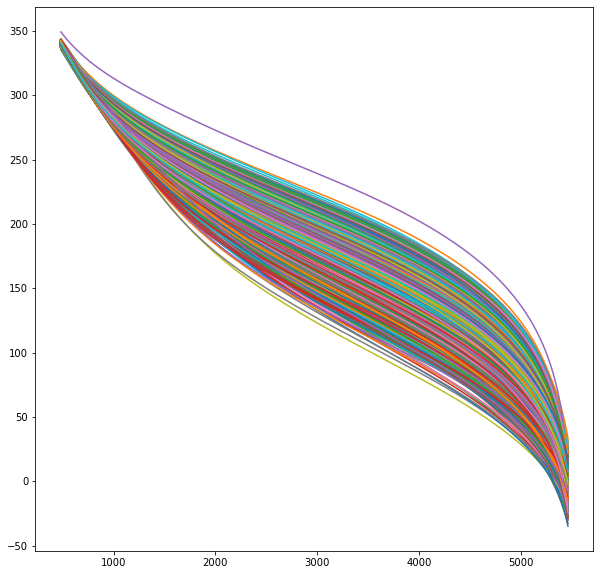

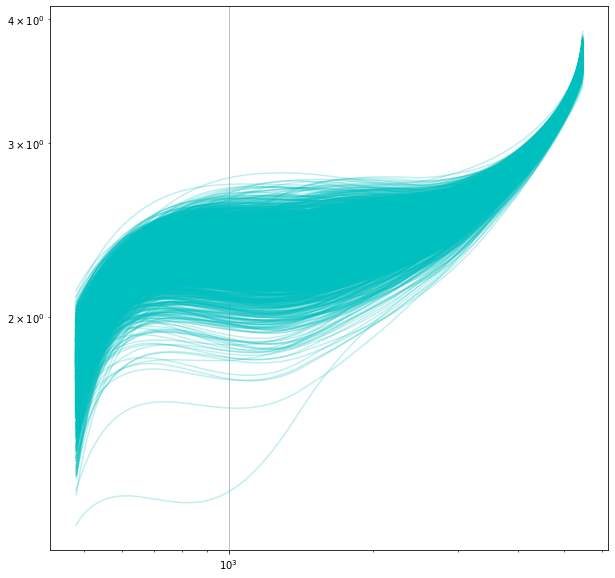

In [107]:
mc = sol['mc']
mc.mc_full['state'][0].shape
X = mc.mc_full['state']
xf = mc.xf

fun = np.log
for x in np.transpose(X, (2,1,0)):
    k = x[2] >= 480
    
    plt.figure(1, figsize=(10,10))
    plt.loglog(x[2,k], fun(x[0,k]/1000-3396.2), 'c', alpha=0.25)
    plt.grid(True)
    
    plt.figure(2, figsize=(10,10))
    plt.plot(x[2,k], x[1,k]/1000)
    

plt.figure(1, figsize=(10,10))
plt.loglog(data['v'], fun(data['h'].T/1000), 'k')    
plt.grid(True)
if 0:
    plt.axis([475, 720, 4.5, 17]) # end
    
plt.figure(2, figsize=(10,10))
plt.plot(data['v'], data['s'].T, 'k')
plt.grid(True)
if 0:
    plt.axis([450, 520, 410, 450]) # end
#     plt.axis([5300, 5550, -100, 100]) # start

plt.show()

In [ ]:
plt.figure(3, figsize=(10,10))
c = np.sin(mc.mc_full['state'][0][3]) #*mc.mc_full['state'][0][1]
plt.scatter(xf.T[1]/1000, xf.T[0]/1000-3396.2, c=c)
plt.colorbar()

plt.figure(4, figsize=(10,10))
c = np.sin(mc.mc_full['state'][0][3])*np.abs(mc.mc_full['state'][0][1])
plt.scatter(mc.mc_full['state'][0][1], np.degrees(mc.mc_full['state'][0][3]), c=xf.T[1]/1000-np.mean(xf.T[1]/1000))
plt.colorbar()

In [ ]:
mc.mc_full['state'][0].shape

In [ ]:
mc = sol['mc']
x0 = mc.mc_full['state'][0][:-1]
MCAnalyze(x0, mc.xf)

# Multiple MC Analysis

In [ ]:
data = loadmat(os.path.join('C:\\Users\cdnoyes\\Documents\\GitHub\\Research\\Matlab\\','solutions_cl_ddp_max.mat'), squeeze_me=True)


In [ ]:
out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\margin', {'N': 3000,'parametric': True})

In [ ]:
# out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\beta_sweep')
out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\all_unc')

In [ ]:
plt.figure()
plt.plot(np.linspace(0,0.75,10), out[:,1,0]*1000)
plt.plot(np.linspace(0,0.75,10), out[:,1,1:])
plt.figure()
plt.plot(np.linspace(0,0.75,10), out[:,0,:])
plt.show()

In [ ]:
mdir = "E:\Documents\GitHub\Research\Matlab"
fname = 'Beta8.mat'
# mdir = 'E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\' 
# fname = "Robust31.mat"  # numbers indicate weights wh and ws
# fname = "FixedGainTestSolution.mat"

data = loadmat(os.path.join(mdir,fname))

In [ ]:
P0 = data['input'][0][0][2]
N = 2000
x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

# X0, mw, cw = Unscented.Transform(x0, P0, k=4)
# X0 = X0.T

mass = 5000.

print(X0.shape)
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
print(X0.shape)

data.keys()


In [ ]:
C = ddp_controller(data)
v = data['v'].squeeze()    
xr = C.ref(v)
xr[1] = np.degrees(xr[1])

plt.figure()
plt.plot(v, C.u(v))
# plt.plot(v, C.K(v)[0:2].T)

plt.figure()
plt.plot(v, xr.T)

plt.show()    

In [ ]:
mc = VMC()
mc.null_sample(N)
# mc.null_sample(7) # for unscented transform comparison only

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.46, 0.35, CD=CD, CL=CL)

In [ ]:
# mc._run(X0, stepsize=0.25, Ef=150000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})
mc._run(X0, stepsize=[5, 0.1, 1], Ef=100000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

mean = np.mean(mc.xf, axis=0)
std = np.std(mc.xf, axis=0)
std_ut = data['ut'][0][0][-1][0] # mean alt, low alt, 3*dr

print("3-sigma Low Altitude\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(mean[0]/1000-3396.2-3*std[0]/1000, std_ut[1]))
print("3-sigma DR\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(3*std[1]/1000, std_ut[2]))

In [ ]:
mc.xf.shape  # N x n 

if 0: # Set X0 to unscented above to debug 
    vu = data['ut'][0][0][0]
    xu = data['ut'][0][0][1].T # 
    uu = data['ut'][0][0][2].T

    k = 7

    plt.figure(666, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[0]/1000-3396.2)

    plt.plot(vu, xu[:k].T/1000, 'k--')   

    plt.grid(1)
    plt.figure(669, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[1]/1000)

    plt.plot(vu, xu[2*k:3*k].T, 'k--')   

    plt.grid(1)
    plt.figure(668, figsize=(10,10))
    for traj, control in zip(mc.mc, mc.mcu):
        plt.plot(traj.T[2], control)

    plt.plot(vu, uu, 'k--')   
    plt.grid(1)

#     plt.figure(667, figsize=(10,10))
#     for traj, aero in zip(mc.mc, mc.mca):
#         plt.plot(traj.T[2], aero)

#     # plt.plot(vu, xu[:k].T/1000, 'k--')   
#     plt.plot(v, xr[0].T, 'k')
#     plt.grid(1)

xf = mc.xf.T
plt.figure()
plt.scatter(xf[2], xf[0]/1000-3396.2, c=x0[3])
plt.grid(1)

plt.figure()
plt.scatter(xf[2], xf[1]/1000, c=x0[3])
plt.colorbar()
plt.grid(1)

# Propagate initial covariance to monotonic velocity point

In [ ]:
P0 = np.diag([1, ])  # h s fpa (no velocity term) 

x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

mass = 5000.
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 

mc = VMC()
mc.null_sample(N)

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.408, 0.357, CD=CD, CL=CL)

mc._run(X0, stepsize=[5, 0.1, 1], Ef=50000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

# Linear vs UT vs Monte Carlo
## Open Loop

In [ ]:
mdir = 'E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\linear_comparison' 
# fname = "Robust31.mat"  # numbers indicate weights wh and ws
fname = "open_loop.mat"

data = loadmat(os.path.join(mdir,fname))

MC = MonteCarlo(data.copy(), N=5000, debug=False)
# UT = MonteCarlo(data, N=2000, debug=True)

In [ ]:
## Linear estimates via DA 
mass = 5000.
x0 = np.append(data['mean'].T[0], mass)
x0[[1,2]] = x0[[2,1]]
Vf = data['v'][-1]
V0 = data['v'][0]

P0 = np.zeros((4,4))
Vars = np.diag(data['input'][0][0][3]).copy()
Vars[[1,2]] = Vars[[2,1]]
P0[:3, :3] =   np.diag(Vars)# h fpa s (no velocity term) 
# FIX: covariances are in different order than states
names = ['r', 's', 'fpa', 'm']
x0d = da.make(x0, names, 1)
du = da.make([0], 'u', 1)[0]

vehicle = ConstantAeroEV(1.408, 0.357)
model = Entry(VehicleModel=vehicle, DifferentialAlgebra=True, Velocity=True, Longitudinal=True)
controller = ddp_controller(data)

X = [x0d]
V = V0.copy()
N = 1000
dv = (Vf-V0)/(N-1)
print(V0, Vf, dv)
for i in range(N-1):
#     print(i, X[-1])
    L,D = model.aeroforces(X[-1][0], V, mass)
    u = controller(V, X[-1], L, D) + du # (self, E, x, L, D)
    x = RK4(model.dynamics((u, [], [])), X[-1], np.linspace(V, V+dv[0], 5).squeeze(), ())[-1]
    X.append(x)
    V += dv

STM = da.jacobian(X[-1], names)
P = STM.dot(P0).dot(STM.T)
S = np.diag(P)**0.5
print("Three sigma low altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf -3*S[0])/1000))
print("Three sigma high range error\nLinear: {:.3f}".format(3*S[1]/1000))

In [ ]:
# r s gamma (m) u 
# da.jacobian(X[-1], names+['u']) # 4 x 6 matrix 

submatrix(da.jacobian(X[-1], names+['u']), rows, cols)

In [ ]:
# Compute Apollo gains wrt to velocity?? 
rows = [0,1,2]
cols = rows + [-1] # get the derivs wrt controls too 
stm  = [np.vstack([submatrix(da.jacobian(x, names+['u']), rows, cols), np.eye(4)[-1]]) for x in X]

print(stm[-1])

# get adjoints 
dJdx = [-1.0/np.tan(X[-1][2].constant_cf), 1, 0, 0]
dJdx = [-1.0/np.tan(X[-1][2].constant_cf), 1, 0, 0]



stmi = [np.linalg.inv(st) for st in stm]
stmf = stm[-1]
C = np.dot(dJdx, stmf)
L = np.array([np.dot(C, si) for si in stmi])

In [ ]:
v = np.linspace(V0, Vf, N).squeeze()

plt.figure()
plt.plot(v[v>600], L[v>600])
plt.legend(['h','s','fpa','u'])
plt.grid(1)
plt.show()

plt.figure()
plt.title('Adjoints Scaled < 1')
plt.plot(v[v>600], L[v>600]/np.max(L[v>600],axis=0))
plt.legend(['h','s','fpa','u'])
plt.grid(1)
plt.show()

vmin = 1000
for i in [0,1,2]:
    plt.figure()
    plt.plot(v[v>vmin], L[v>vmin,i]/L[v>vmin,3])
#     plt.legend(['h','s','fpa'])
    plt.grid(1)
plt.show()

## Closed Loop

In [ ]:
mdir = 'E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\linear_comparison' 
fname = "closed_loop.mat"

data = loadmat(os.path.join(mdir,fname))

MC = MonteCarlo(data.copy(), N=2000, debug=False)


In [ ]:
## Linear estimates via DA 
mass = 5000.
x0 = np.append(data['mean'].T[0], mass)
x0[[1,2]] = x0[[2,1]]
Vf = data['v'][-1]
V0 = data['v'][0]

P0 = np.zeros((4,4))
Vars = np.diag(data['input'][0][0][3]).copy()
Vars[[1,2]] = Vars[[2,1]]
P0[:3, :3] =   np.diag(Vars)# h fpa s (no velocity term) 

names = ['r', 's', 'fpa', 'm']
x0d = da.make(x0, names, 1)


vehicle = ConstantAeroEV(1.408, 0.357)
model = Entry(VehicleModel=vehicle, DifferentialAlgebra=True, Velocity=True, Longitudinal=True)
controller = ddp_controller(data)


# Without saturating the control
X = [x0d]
V = V0.copy()
N = 1000
dv = (Vf-V0)/(N-1)
print(V0, Vf, dv)
for i in range(N-1):
#     print(i, X[-1])
    X[-1][0] += 3396.2e3 # both aero and controller expect radius, dynamics use h 
    L,D = model.aeroforces(X[-1][0], V, mass)
#     print(L,D)
    u = controller(V, X[-1], L, D, saturate=False) # (self, E, x, L, D)
#     print(u)
    X[-1][0] -= 3396.2e3
    x = RK4(model.dynamics((u, [], [])), X[-1], np.linspace(V, V+dv[0], 5).squeeze(), ())[-1]
    X.append(x)
    V += dv

STM = da.jacobian(X[-1], names)
P = STM.dot(P0).dot(STM.T)
S = np.diag(P)**0.5
# print((X[-1][0].constant_cf -3*S[0])/1000, 3*S[1]/1000)
print("Unsaturated control")
print("Three sigma low altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf -3*S[0])/1000))
print("Three sigma high range error\nLinear: {:.3f}".format(3*S[1]/1000))

# With saturating the control
X = [x0d]
V = V0.copy()
N = 1000
dv = (Vf-V0)/(N-1)
print(V0, Vf, dv)
for i in range(N-1):
#     print(i, X[-1])
    X[-1][0] += 3396.2e3 # both aero and controller expect radius, dynamics use h 
    L,D = model.aeroforces(X[-1][0], V, mass)
#     print(L,D)
    u = controller(V, X[-1], L, D, saturate=True) # (self, E, x, L, D)
#     print(u)
    X[-1][0] -= 3396.2e3
    x = RK4(model.dynamics((u, [], [])), X[-1], np.linspace(V, V+dv[0], 5).squeeze(), ())[-1]
    X.append(x)
    V += dv

STM = da.jacobian(X[-1], names)
Ps = STM.dot(P0).dot(STM.T)
Ss = np.diag(P)**0.5
print("Saturated control")
print("Three sigma low altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf -3*Ss[0])/1000))
print("Three sigma high range error\nLinear: {:.3f}".format(3*Ss[1]/1000))